<a href="https://www.kaggle.com/code/samithsachidanandan/stock-price-prediction-in-python-with-pytorch?scriptVersionId=266538609" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#!pip install yfinance


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.optim as optim

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
device 

device(type='cpu')

In [5]:
ticker = 'AMD'
df = yf.download(ticker, '2020-01-01')

/tmp/ipykernel_13/4218411562.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [6]:
df 

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2020-01-02,49.099998,49.250000,46.630001,46.860001,80331100
2020-01-03,48.599998,49.389999,47.540001,48.029999,73127400
2020-01-06,48.389999,48.860001,47.860001,48.020000,47934900
2020-01-07,48.250000,49.389999,48.040001,49.349998,58061400
2020-01-08,47.830002,48.299999,47.139999,47.849998,53767000
...,...,...,...,...,...
2025-10-01,164.009995,164.179993,160.490005,160.929993,39895200
2025-10-02,169.729996,171.059998,166.119995,168.679993,55475200


<Axes: xlabel='Date'>

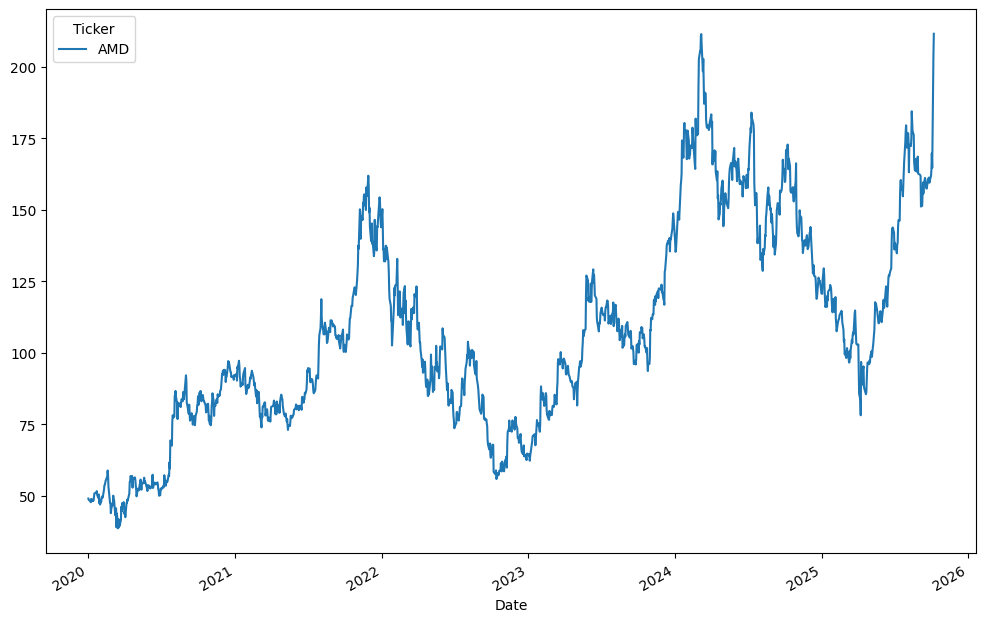

In [7]:
df.Close.plot(figsize = (12,8))

In [8]:
scaler = StandardScaler()

df['Close'] =  scaler.fit_transform(df['Close'])

In [9]:
df.Close

Ticker,AMD
Date,
2020-01-02,-1.602078
2020-01-03,-1.615911
2020-01-06,-1.621721
2020-01-07,-1.625594
2020-01-08,-1.637214
...,...
2025-10-01,1.576985
2025-10-02,1.735232
2025-10-03,1.595244


In [10]:
seq_length =30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close [i:i + seq_length])

data = np.array(data)



In [11]:
data

array([[[-1.60207825],
        [-1.61591109],
        [-1.62172086],
        ...,
        [-1.47204954],
        [-1.46955962],
        [-1.45185361]],

       [[-1.61591109],
        [-1.62172086],
        [-1.62559403],
        ...,
        [-1.46955962],
        [-1.45185361],
        [-1.4302743 ]],

       [[-1.62172086],
        [-1.62559403],
        [-1.63721357],
        ...,
        [-1.45185361],
        [-1.4302743 ],
        [-1.38656259]],

       ...,

       [[ 1.56868541],
        [ 1.68073107],
        [ 1.55900225],
        ...,
        [ 1.51556693],
        [ 1.57698477],
        [ 1.73523249]],

       [[ 1.68073107],
        [ 1.55900225],
        [ 1.64919221],
        ...,
        [ 1.57698477],
        [ 1.73523249],
        [ 1.59524422]],

       [[ 1.55900225],
        [ 1.64919221],
        [ 1.66330198],
        ...,
        [ 1.73523249],
        [ 1.59524422],
        [ 2.67531255]]])

In [12]:

train_size = int(0.8 * len(data))

X_train = torch.from_numpy (data[: train_size, :-1, : ]).type(torch.Tensor).to(device)
y_train = torch.from_numpy (data[: train_size, -1, : ]).type(torch.Tensor).to(device)
X_test = torch.from_numpy (data[train_size :, :-1, : ]).type(torch.Tensor).to(device)
y_test = torch.from_numpy (data[train_size : , -1, : ]).type(torch.Tensor).to(device)

In [13]:
class PredictionModel( nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim


        self.lstm  = nn.LSTM(input_dim,  hidden_dim, num_layers, batch_first= True, dropout=0.2 )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device )
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device )

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out 




    

In [14]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
num_epochs = 200

for i in range (num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i  % 25 ==0:
        print(i, loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 tensor(0.9830, grad_fn=<MseLossBackward0>)
25 tensor(0.0332, grad_fn=<MseLossBackward0>)
50 tensor(0.0201, grad_fn=<MseLossBackward0>)
75 tensor(0.0173, grad_fn=<MseLossBackward0>)
100 tensor(0.0159, grad_fn=<MseLossBackward0>)
125 tensor(0.0150, grad_fn=<MseLossBackward0>)
150 tensor(0.0136, grad_fn=<MseLossBackward0>)
175 tensor(0.0127, grad_fn=<MseLossBackward0>)


In [17]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [18]:
train_rmse = mean_squared_error(y_train[:,0], y_train_pred[:,0],squared=False)
test_rmse = mean_squared_error(y_test[:,0], y_test_pred[:,0],squared=False)

In [19]:
train_rmse

3.9542937

In [20]:
test_rmse

4.851763

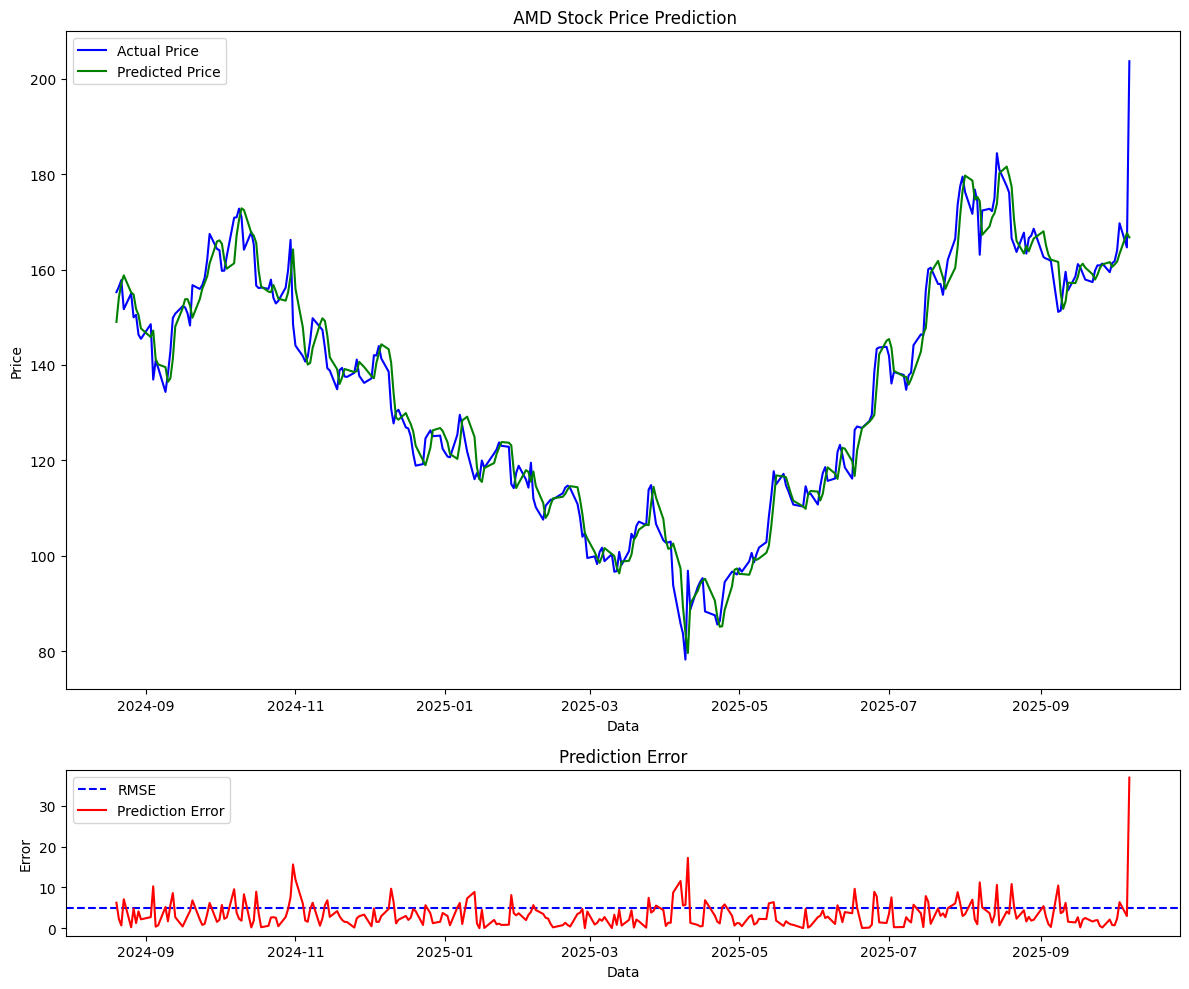

In [21]:
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4,1)
ax1 =fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label= 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label= 'Predicted Price')
ax1.legend()
plt.title(f" {ticker} Stock Price Prediction")
plt.xlabel('Data')
plt.ylabel('Price')



ax2 = fig.add_subplot(gs [3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Data')
plt.ylabel('Error')
plt.tight_layout()
plt.show()



